# Sweeps - Eigenmode matrix

### Prerequisite
You need to have a working local installation of Ansys

## 1. Perform the necessary imports and create a QDesign in Metal first.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
from qiskit_metal.analyses.quantization import EPRanalysis

In [3]:
# Create the design in Metal
# Create a design by specifying the chip size and open Metal GUI.

design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

### In this example, the design consists of 1 qubit and 1 CPW connected to OpenToGround.

In [4]:
# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

# Remove all qcomponents from GUI.
design.delete_all_components()

# So as to demonstrate the quality factor outputs easily, the
#subtrate material type is being changed to FR4_epoxy from the
#default of silicon
design.chips.main.material = 'FR4_epoxy'

q1 = TransmonPocket(
    design,
    'Q1',
    options=dict(pad_width='425 um',
                 pocket_height='650um', 
                 hfss_inductance = '17nH',
                 connection_pads=dict(
                     readout=dict(loc_W=+1, loc_H=+1, pad_width='200um'))))
otg = OpenToGround(design,
                   'open_to_ground',
                   options=dict(pos_x='1.75mm', pos_y='0um', orientation='0'))
readout = RouteMeander(
    design, 'readout',
    Dict(
        total_length='6 mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead=dict(start_straight='100um'),
        pin_inputs=Dict(start_pin=Dict(component='Q1', pin='readout'),
                        end_pin=Dict(component='open_to_ground', pin='open')),
    ))

gui.rebuild()
gui.autoscale()

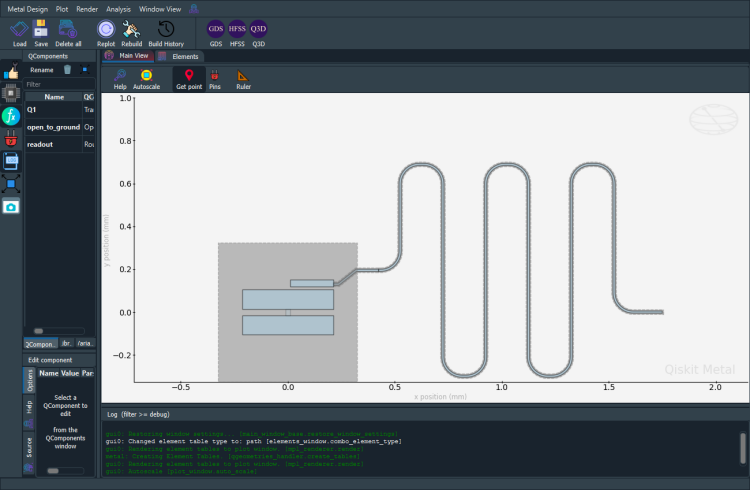

In [5]:
gui.screenshot()

## 2 Metal passes information to 'hfss' simulator, and gets a solution matrix.


In [6]:
# Create a separate analysis object for the combined qbit+readout.
eig_qres = EPRanalysis(design, "hfss")


Prepare data to pass as arguments for method run_sweep().  

Method run_sweep() will open the simulation software if software is not open already.

In [7]:
### for render_design()
# Render every QComponent in QDesign.
render_qcomps = []

# Identify which kind of pins in Ansys. 
# Follow details from renderer in
# QHFSSRenderer.render_design.
# No pins are open, so don't need to utilize render_endcaps.
open_terminations = []

#List of tuples of jj's that shouldn't be rendered.  
#Follow details from renderer in QHFSSRenderer.render_design.
render_ignored_jjs = []

# Either calculate a bounding box based on the location of 
# rendered geometries or use chip size from design class.
box_plus_buffer = True

In [8]:
# For simulator hfss, the setup options are :
# min_freq_ghz, n_modes, max_delta_f, max_passes, min_passes, min_converged=None,
# pct_refinement, basis_order

# If you don't pass all the arguments, the default is determined by 
# QHFSSRenderer's default_options.

# If a setup named "sweeper_em_setup" exists in the project, it will be deleted, 
# and a new setup will be added.

eig_qres.sim.setup.name="sweeper_em_setup"
eig_qres.sim.setup.min_freq_ghz=4
eig_qres.sim.setup.n_modes=2
eig_qres.sim.setup.max_passes=15
eig_qres.sim.setup.min_converged = 2
eig_qres.sim.setup.max_delta_f = 0.2

eig_qres.setup.junctions.jj.rect = 'JJ_rect_Lj_Q1_rect_jj'
eig_qres.setup.junctions.jj.line = 'JJ_Lj_Q1_rect_jj_'


- Connect to Ansys HFSS, eigenmode solution.
- Rebuild QComponents in Metal.
- Render QComponents within HFSS and setup.
- Delete/Clear the HFSS between each calculation of solution matrix.
- Calculate solution matrix for each value in option_sweep.

#### Return a dict and return code.  If the return code is zero, there were no errors detected.  
#### The dict has:  key = each value used to sweep, value = data from simulators

#### This could take minutes based size of design.

In [9]:
#Note: The method will connect to Ansys, activate_eigenmode_design(), add_eigenmode_setup().

all_sweeps, return_code = eig_qres.run_sweep(readout.name,
                                        'total_length', 
                                        ['10mm', '11mm', '12mm'],
                                        render_qcomps,
                                        open_terminations,
                                         ignored_jjs=render_ignored_jjs,
                                        design_name="GetEigenModeSolution", 
                                       box_plus_buffer=box_plus_buffer
                                      )


INFO 08:11AM [connect_project]: Connecting to Ansys Desktop API...
INFO 08:11AM [load_ansys_project]: 	Opened Ansys App
INFO 08:11AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 08:11AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project23
INFO 08:11AM [connect_design]: No active design found (or error getting active design).
INFO 08:11AM [connect]: 	 Connected to project "Project23". No design detected
INFO 08:11AM [connect_design]: 	Opened active design
	Design:    GetEigenModeSolution_hfss [Solution type: Eigenmode]
WARNING 08:11AM [connect_setup]: 	No design setup detected.
WARNING 08:11AM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:11AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:11AM [get_setup]: 	Opened setup `sweeper_em_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:11AM [analyze]: Analyzing setup sweeper_em_setup
08:26AM 34s INFO [get_f_convergence]: Saved convergences to 

Design "GetEigenModeSolution_hfss" info:
	# eigenmodes    2
	# variations    1
Design "GetEigenModeSolution_hfss" info:
	# eigenmodes    2
	# variations    1

        energy_elec_all       = 5.19788159957566e-25
        energy_elec_substrate = 4.2287113157029e-25
        EPR of substrate = 81.4%

        energy_mag    = 8.01738203686217e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]

  Mode 0 at 7.53 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  2.599e-25 4.009e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.71%
	jj                1.6736  (+)        0.0750176
		(U_tot_cap-U_tot_ind)/mean=-22.21%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.8135451403987578

  Mode 1 at 8.86 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ

WARNING 08:27AM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:27AM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 44.4% is > 15%.                     
Is the simulation converged? Proceed with caution



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project23\GetEigenModeSolution_hfss\2021-08-18 08-26-35.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization


ERROR 08:27AM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 44.4% is > 15%.                     
Is the simulation converged? Proceed with caution


Finished the diagonalization
Pm_norm=
modes
0    0.635168
1    0.817290
dtype: float64

Pm_norm idx =
      jj
0   True
1  False
*** P (participation matrix, not normlz.)
         jj
0  1.556815
1  0.019960

*** S (sign-bit matrix)
   s_jj
0     1
1     1
*** P (participation matrix, normalized.)
      0.99
      0.02

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       424     20.1
      20.1    0.239

*** Chi matrix ND (MHz) 
       499     10.1
      10.1   0.0723

*** Frequencies O1 PT (MHz)
0    7100.043062
1    8845.729528
dtype: float64

*** Frequencies ND (MHz)
0    7067.159806
1    8847.889665
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
eigenmode,
0,7100.04
1,8845.73


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0      1
Lj                 
10 0  498.59  10.14
   1   10.14   0.07

INFO 08:27AM [connect_design]: 	Opened active design
	Design:    GetEigenModeSolution_hfss [Solution type: Eigenmode]
INFO 08:27AM [get_setup]: 	Opened setup `sweeper_em_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:27AM [analyze]: Analyzing setup sweeper_em_setup
08:36AM 21s INFO [get_f_convergence]: Saved convergences to C:\workspace\qiskit-metal\docs\tut\4-Analysis\hfss_eig_f_convergence.csv


Design "GetEigenModeSolution_hfss" info:
	# eigenmodes    2
	# variations    1
Design "GetEigenModeSolution_hfss" info:
	# eigenmodes    2
	# variations    1

        energy_elec_all       = 1.24548064887814e-24
        energy_elec_substrate = 1.01220397065148e-24
        EPR of substrate = 81.3%

        energy_mag    = 6.56191412175113e-26
        energy_mag % of energy_elec_all  = 5.3%
        

Variation 0  [1/1]

  Mode 0 at 7.47 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               94.7%  6.227e-25 3.281e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.78%
	jj               1.61044  (+)        0.0709035
		(U_tot_cap-U_tot_ind)/mean=-21.66%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.8127014832090866

  Mode 1 at 8.07 GHz   [2/2]
    Calculating ℰ_magnetic,

WARNING 08:36AM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:36AM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 43.3% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:36AM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 43.3% is > 15%.                     
Is the simulation converged? Proceed with caution



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project23\GetEigenModeSolution_hfss\2021-08-18 08-36-22.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    0.639346
1    0.806611
dtype: float64

Pm_norm idx =
      jj
0   True
1  False
*** P (participation matrix, not normlz.)
         jj
0  1.503817
1  0.082799

*** S (sign-bit matrix)
   s_jj
0     1
1     1
*** P (participation matrix, normalized.)
      0.96
     0.083

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       394     73.4
      73.4     3.42

*** Chi matrix ND (MHz) 
       532     18.8
      18.8    0.297

*** Frequencies O1 PT (MHz)
0    7036.474625
1    8032.650030
dtype: float64

*** Frequencies ND (MHz)
0    6983.674726
1    8048.708620
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
eigenmode,
0,7036.47
1,8032.65


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0      1
Lj                 
10 0  532.36  18.82
   1   18.82   0.30

INFO 08:36AM [connect_design]: 	Opened active design
	Design:    GetEigenModeSolution_hfss [Solution type: Eigenmode]
INFO 08:37AM [get_setup]: 	Opened setup `sweeper_em_setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 08:37AM [analyze]: Analyzing setup sweeper_em_setup
08:49AM 07s INFO [get_f_convergence]: Saved convergences to C:\workspace\qiskit-metal\docs\tut\4-Analysis\hfss_eig_f_convergence.csv


Design "GetEigenModeSolution_hfss" info:
	# eigenmodes    2
	# variations    1
Design "GetEigenModeSolution_hfss" info:
	# eigenmodes    2
	# variations    1

        energy_elec_all       = 1.24148729817218e-24
        energy_elec_substrate = 1.00761523148401e-24
        EPR of substrate = 81.2%

        energy_mag    = 9.86581588344368e-25
        energy_mag % of energy_elec_all  = 79.5%
        

Variation 0  [1/1]

  Mode 0 at 7.33 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               20.5%  6.207e-25 4.933e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.93%
	jj              0.349277  (+)        0.0148271
		(U_tot_cap-U_tot_ind)/mean=-5.98%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.8116194446511892

  Mode 1 at 7.62 GHz   [2/2]
    Calculating ℰ_magnetic,

WARNING 08:49AM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 08:49AM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 37.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 08:49AM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 37.6% is > 15%.                     
Is the simulation converged? Proceed with caution



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project23\GetEigenModeSolution_hfss\2021-08-18 08-49-08.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    0.766393
1    0.663454
dtype: float64

Pm_norm idx =
     jj
0  True
1  True
*** P (participation matrix, not normlz.)
         jj
0  0.344174
1  1.265842

*** S (sign-bit matrix)
   s_jj
0     1
1     1
*** P (participation matrix, normalized.)
      0.26
      0.84

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
      28.6      189
       189      313

*** Chi matrix ND (MHz) 
       526     -492
      -492      624

*** Frequencies O1 PT (MHz)
0    7209.141624
1    7215.058834
dtype: float64

*** Frequencies ND (MHz)
0    7432.783625
1    6939.798837
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
eigenmode,
0,7209.14
1,7215.06


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0       1
Lj                  
10 0  526.43 -492.01
   1 -492.01  624.37

In [10]:
all_sweeps.keys()

dict_keys(['10mm', '11mm', '12mm'])

In [11]:
# For example, just one group of solution data.
all_sweeps['10mm'].keys()


dict_keys(['option_name', 'variables', 'sim_variables'])

In [12]:
all_sweeps['10mm']


{'option_name': 'total_length',
 'variables': {'energy_elec': 5.19788159957566e-25,
  'energy_elec_sub': 4.2287113157029e-25,
  'energy_mag': 8.01738203686217e-27},
 'sim_variables': {'sim_setup_name': 'sweeper_em_setup',
  'convergence_t':              Solved Elements  Max Delta Freq. %
  Pass Number                                    
  1                      12372                NaN
  2                      16089           46.90700
  3                      20923           26.83400
  4                      27201           12.39700
  5                      35009            5.13720
  6                      45251            3.05090
  7                      58833            1.58050
  8                      76494            1.37040
  9                      99448            0.75837
  10                    129285            0.63878
  11                    168080            0.27581
  12                    218509            0.35048
  13                    284068            0.39353
  14       

In [13]:
all_sweeps['10mm']['variables']

{'energy_elec': 5.19788159957566e-25,
 'energy_elec_sub': 4.2287113157029e-25,
 'energy_mag': 8.01738203686217e-27}

In [14]:
all_sweeps['10mm']['sim_variables']['convergence_t']

,Solved Elements,Max Delta Freq. %
Pass Number,,
1,12372,NaN
2,16089,46.90700
3,20923,26.83400
4,27201,12.39700
5,35009,5.13720
6,45251,3.05090
7,58833,1.58050
8,76494,1.37040
9,99448,0.75837


In [15]:
all_sweeps['10mm']['sim_variables']['convergence_f']

,re(Mode(1)) [g],re(Mode(2)) [g]
Pass [],,
1,5.569390,11.880396
2,4.638777,6.307600
3,5.883535,7.416275
4,6.612905,7.967902
5,6.952620,8.203356
6,7.139302,8.453635
7,7.252139,8.571936
8,7.325233,8.689408
9,7.365970,8.755306


In [16]:
# Uncomment the next close simulation software. 
#eig_qres.sim.close()

In [17]:
# Uncomment next line if you would like to close the gui
#gui.main_window.close()